# Subevent Collaborative Filtering

## Import

In [259]:
import pandas as pd
import surprise as sur
import numpy as np
import matplotlib.pyplot as plt
from time import time
from collections import defaultdict
import statistics
import math

from sklearn import preprocessing as pre
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV


## Utils

In [187]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## Read csv

Data obtained with this query

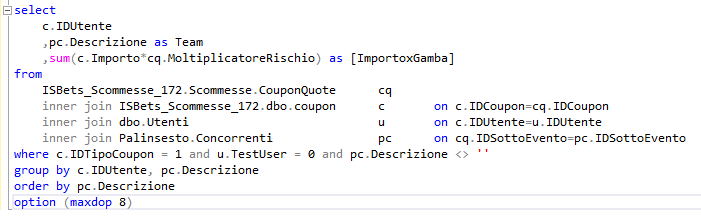

per sapere quanto è piaciuto un evento ad un utente guardare fra tutte le giocate dell'utente quanto ci ha scommesso rispetto agli altri

sortare gli importi per ogni evento
assegnare un voto per ogni evento a seconda dei percentili
sia su importo totale 
sia su numero di volte

pesare gli importi con distanza nel tempo

In [194]:
df = pd.read_csv(r'C:\Users\a.ceci\Desktop\Alex\AI Data\SubEventsCF\itemCFdata.csv', skiprows=0)

In [195]:
df.head()

,IDUtente,Team,Importo
0,1773,(Mercedes) L.Hamilton,105.8940
1,536,(Racing Point) S.Perez,57.6900
2,15746,07 Vestur,5.1579
3,4734,1 Dezembro,250.0000
4,9295,1 Dezembro,5000.0000


In [196]:
df.shape

(179123, 3)

In [197]:
df.pivot_table(index='IDUtente', columns='Team', values='Importo')

Team,(Mercedes) L.Hamilton,(Racing Point) S.Perez,07 Vestur,1 Dezembro,1. FFC Frankfurt Women,1860 Munich,1877 Alemdag,1922 Konyaspor,4 de Julho,9 de Octubre,...,Zira IK,Ziraat Bankasi Ankara,Zlate Moravce,Zlatibor,Znamya Noginsk,Zob Ahan,Zonguldak Komurspor,Zoo Kericho FC,Zrinjski Mostar,Zweigen Kanazawa
IDUtente,,,,,,,,,,,,,,,,,,,,,
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Analysis

Plot histogram of whole population

<AxesSubplot:>

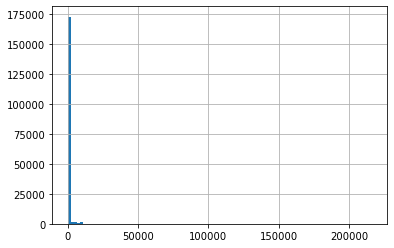

In [198]:
df['Importo'].hist(bins=100)

<AxesSubplot:>

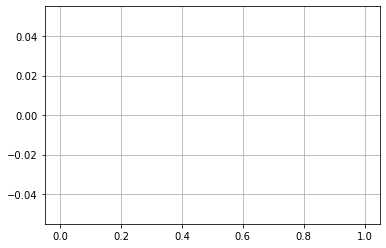

In [261]:
df['Importo'][df['Importo']>10000].hist(bins=100)

Showing only one column probably due to skewed data and very big outliers.
Taking the log of all items should solve this.

<AxesSubplot:>

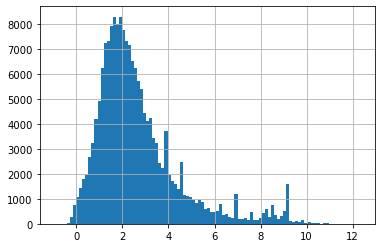

In [199]:
np.log(df['Importo']).hist(bins=100)

Looks like a beta distribution but with a bit of a tail on the right side (convolution?)

Check how many items there are for each team

In [200]:
df.value_counts('Team')

Team
Manchester United          1636
Chelsea                    1424
Manchester City            1389
Arsenal                    1376
Tottenham Hotspur          1337
                           ... 
Inglewood United SC           1
Inegol Bld                    1
Indios de Mayaguez            1
Indiana State Sycamores       1
(Mercedes) L.Hamilton         1
Length: 5916, dtype: int64

## Data preparation

We want only teams that have been bet on a significant amount of times

In [201]:
df = pd.read_csv(r'C:\Users\a.ceci\Desktop\Alex\AI Data\SubEventsCF\itemCFdata.csv', skiprows=0)
#Check for teams that have been bet on less times than arbitrary value
min_inst = 150
team_count = df.value_counts('Team') < min_inst
#Get list of teams to drop
teams_to_drop = team_count.where(team_count==True).dropna().index
#Drop from dataframe
df = df[~df['Team'].isin(teams_to_drop)]

#Amount values must be in log form to mitigate bias
df['Importo'] = np.log(df['Importo'])
#Scale values to standard range for algoritmh to consume
#Normalize importo to set a standard range of ratings
scaler = pre.MinMaxScaler(feature_range=(0, 5))
df['Importo'] = scaler.fit_transform(df[['Importo']])

In [202]:
df.value_counts('Team')

Team
Manchester United     1636
Chelsea               1424
Manchester City       1389
Arsenal               1376
Tottenham Hotspur     1337
                      ... 
Bochum                 158
FC Twente Enschede     158
Wazito                 158
Holstein Kiel          156
Portsmouth             150
Length: 196, dtype: int64

## Surprise

In [203]:
#Load df into surprise Dataset
reader = sur.reader.Reader(name=None, line_format=u'user item rating', sep=None, rating_scale=(0, 5), skip_lines=0)
data = Dataset.load_from_df(df, reader)

### Training

In [233]:
time_start = time()

# Build test dataset
trainset = data.build_full_trainset()

#Options for algorithm
sim_options = {'name': 'pearson',
               'user_based': False  #compute similarities between items
               }
#Using K-Nearest Neighbors
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

print('\nTime elapsed:')
print(time() - time_start)

Computing the pearson similarity matrix...
Done computing similarity matrix.

Time elapsed:
0.5597810745239258


## Predict


#### Single user

In [234]:
time_start = time()
predictions = []

for team in set(df['Team']):
    predictions.append(algo.predict(15186, team))

top_n = get_top_n(predictions, n=10)
print('Time elapsed: ', time() - time_start,'s')
top_n

Time elapsed:  0.22177386283874512 s


defaultdict(list,
            {15186: [('Paris Saint Germain', 1.1077626191291203),
              ('Werder Bremen', 1.1045585158556188),
              ('Cadiz', 1.103043647352336),
              ('Ajax', 1.100935355129146),
              ('Osasuna', 1.100670993874662),
              ('Bayern Munich', 1.100129457699406),
              ('AEK Athens', 1.0981405239730417),
              ('Celta Vigo', 1.0967508209439936),
              ('Torino', 1.0964352492373015),
              ('Club Brugge', 1.0962958243100276)]})

#### All Users testing

In [235]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

errors = []

for pred in predictions:
    error_sq = (pred[2]-pred[3])**2
    errors.append(error_sq)

mse = sum(errors)/len(errors)
rmse = math.sqrt(mse)

print('MSE: ', mse)
print('RMSE: 'rmse)

1.071144376308592
1.0349610506239315
